In [1]:
import os
from collections import defaultdict
from datetime import date

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from IPython.display import Image

In [2]:
load_dotenv()
CLIENT_ID = os.environ.get('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

# TASK 1: postal codes of a neighborhoods in Toronto
### Scrape Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

### 1.1 get source code of the html page:

In [3]:
postal_codes_wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

source_html = requests.get(postal_codes_wiki_url).text

### 1.2 save source code to html file and open it with BeautifulSoup:

In [4]:
with open('wiki_page.html', 'w') as html_file:
    html_file.write(source_html)

print('Save source page to html file - done!')

Save source page to html file - done!


In [5]:
with open('wiki_page.html') as html_file:
    soup = BeautifulSoup(html_file, 'html.parser')

print('soup is ready:', soup.title.text)

soup is ready: List of postal codes of Canada: M - Wikipedia


### 1.3 find table

In [6]:
table_body = soup.find('table').tbody
table_rows = table_body.find_all('tr')

### 1.4 create dictionary like -
### {'one postal code area': ('Borough', 'more than one neighborhood')}

In [7]:
combo_dict = defaultdict()

for row in table_rows:
    cols = row.find_all('td')
    row = [sel.text.strip() for sel in cols]
    
    if row and row[1] != 'Not assigned':
        
        # If a cell has a borough but a Not assigned neighborhood, 
        # then the neighborhood will be the same as the borough.
        if row[2] == 'Not assigned':
            row[2] = row[1]
        
        # create dictionary
        if combo_dict.get(row[0]):
            combo_dict[row[0]] = row[1], "%s, %s" % (combo_dict[row[0]][0], row[2])
        else:
            combo_dict[row[0]] = row[1], row[2]

print('length of the combo_dict:', len(combo_dict))

length of the combo_dict: 103


### 1.5 convert dictionary to list like ['Postcode', 'Borough', 'Neighbourhood']

In [8]:
prepare_dataframe = []
for i in combo_dict.items():
    new_list = [i[0]] + [i[1][0]] + [i[1][1]]
    prepare_dataframe.append(new_list)

### 1.6 create pandas datafreme

In [9]:
df_columns = ['Postcode', 'Borough', 'Neighborhood']

df = pd.DataFrame(data=prepare_dataframe, columns=df_columns)

df.sort_values(by='Postcode', inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Scarborough, Malvern"
1,M1C,Scarborough,"Scarborough, Port Union"
2,M1E,Scarborough,"Scarborough, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Etobicoke, St. Phillips"
101,M9V,Etobicoke,"Etobicoke, Thistletown"


### 1.7 Result:

In [10]:
df.shape

(103, 3)

# TASK 2: get the latitude and the longitude coordinates of each neighborhood.

### 2.1 open csv file that has the geographical coordinates of each postal code

In [11]:
df_geo_coords = pd.read_csv('Geospatial_Coordinates.csv')
df_geo_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 2.2 expand current data frame with 2 more columns with zeros

In [12]:
new_df = pd.DataFrame(data=np.zeros((103, 2), dtype=float), columns=['Latitude', 'Longitude'])
df = pd.concat([df, new_df], axis=1)
df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Scarborough, Malvern",0.0,0.0
1,M1C,Scarborough,"Scarborough, Port Union",0.0,0.0
2,M1E,Scarborough,"Scarborough, West Hill",0.0,0.0
3,M1G,Scarborough,Woburn,0.0,0.0
4,M1H,Scarborough,Cedarbrae,0.0,0.0


### 2.3 Check if Post Code data is valid and apply them to current(work) data frame

In [13]:
errors = 0
for i in range(len(df_geo_coords)):
    geo_df = df_geo_coords.iloc[i, :]
    geo_post_code = geo_df[0]
    my_df_post_code = df.iloc[i, 0]
    
    if my_df_post_code == geo_post_code:
        lat = geo_df[1]
        lng = geo_df[2]
        df.at[i, 'Latitude'], df.at[i, 'Longitude'] = round(lat, 7), round(lng, 7)
    else:
        errors += 1

print('errors:', errors)

errors: 0


### 2.4 Result:

In [14]:
print(df.shape)
df.head()

(103, 5)


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Scarborough, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Scarborough, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Scarborough, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [15]:
df.isnull().sum()

Postcode        0
Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

In [16]:
0.0 in df.values

False

In [17]:
# df.to_csv('my_df.csv')

# TASK 3: Explore and cluster the neighborhoods in Toronto.

### 3.1 Show all Toronto neighborhoods

In [18]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Toronto are 43.653963, -79.387207.


In [19]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}; {}'.format(neighborhood, borough)
    label_f = folium.Popup(label, parse_html=True)
    tooltip = folium.Tooltip(label)
    folium.CircleMarker(
        (lat, lng),
        radius=5,
        popup=label_f,
        tooltip=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [20]:
print('number of Toronto neighborhoods:', df.shape[0])

number of Toronto neighborhoods: 103


### 3.2 Load data from Foursquare

In [21]:
LIMIT = 100
VERSION = date.today().strftime("%Y%m%d")
VERSION

'20200127'

In [1]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues

In [23]:
# toronto_venues = getNearbyVenues(
#     names=df['Neighborhood'],
#     latitudes=df['Latitude'],
#     longitudes=df['Longitude']
# )

### Save data to the file and then work only with file if you don't want to load it again from Foursquare

In [24]:
# toronto_venues.to_csv('toronto_venues.csv')

In [25]:
toronto_venues = pd.read_csv('toronto_venues.csv')

In [26]:
print(toronto_venues.shape)
toronto_venues.head()

(2213, 8)


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,"Scarborough, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,1,"Scarborough, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,2,"Scarborough, Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,3,"Scarborough, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,4,"Scarborough, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [27]:
toronto_venues.drop(columns=['Unnamed: 0'], inplace=True, axis=1)

In [28]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 266 uniques categories.


### 3.3 Analyze Each Neighborhood

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to data-frame
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(98, 266)


,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.017857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,Caledonia-Fairbanks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25


### sort the venues in descending order

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### create the new data-frame and display the top 10 venues for each neighborhood

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new data-frame
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Lounge,Skating Rink,Breakfast Spot,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
1,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
2,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Seafood Restaurant,Café,Cheese Shop,Bakery,Steakhouse,Beach
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Auto Workshop,Brewery,Farmers Market,Fast Food Restaurant,Burrito Place,Butcher,Restaurant,Recording Studio,Skate Park
4,Caledonia-Fairbanks,Women's Store,Park,Fast Food Restaurant,Market,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


### 3.4 Cluster Neighborhoods

### Run k-means to cluster the neighborhood into 5 clusters.

In [33]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, random_state=0, n_init=12).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the data-frame
kmeans.labels_[:10]

array([3, 3, 3, 3, 0, 3, 3, 3, 0, 3], dtype=int32)

### new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

### delete rows with 'nan' values, and transform 'Cluster Labels' to int type

In [35]:
toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Scarborough, Malvern",43.806686,-79.194353,8.0,Fast Food Restaurant,Women's Store,Deli / Bodega,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
1,M1C,Scarborough,"Scarborough, Port Union",43.784535,-79.160497,3.0,History Museum,Bar,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Department Store
2,M1E,Scarborough,"Scarborough, West Hill",43.763573,-79.188711,3.0,Electronics Store,Breakfast Spot,Rental Car Location,Mexican Restaurant,Intersection,Medical Center,Pizza Place,Drugstore,Donut Shop,Doner Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,9.0,Coffee Shop,Indian Restaurant,Korean Restaurant,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3.0,Bakery,Bank,Fried Chicken Joint,Hakka Restaurant,Athletics & Sports,Thai Restaurant,Caribbean Restaurant,Gas Station,Discount Store,Dessert Shop


In [36]:
toronto_merged.isnull().sum()

Postcode                  0
Borough                   0
Neighborhood              0
Latitude                  0
Longitude                 0
Cluster Labels            4
1st Most Common Venue     4
2nd Most Common Venue     4
3rd Most Common Venue     4
4th Most Common Venue     4
5th Most Common Venue     4
6th Most Common Venue     4
7th Most Common Venue     4
8th Most Common Venue     4
9th Most Common Venue     4
10th Most Common Venue    4
dtype: int64

In [37]:
toronto_merged.dropna(inplace=True)
# toronto_merged['Cluster Labels'].replace(np.nan, -1, inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged['Cluster Labels'].value_counts()

3    72
0    11
1     7
7     3
9     1
8     1
6     1
5     1
4     1
2     1
Name: Cluster Labels, dtype: int64

In [38]:
print(toronto_merged.shape)
toronto_merged.head()

(99, 16)


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Scarborough, Malvern",43.806686,-79.194353,8,Fast Food Restaurant,Women's Store,Deli / Bodega,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
1,M1C,Scarborough,"Scarborough, Port Union",43.784535,-79.160497,3,History Museum,Bar,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Department Store
2,M1E,Scarborough,"Scarborough, West Hill",43.763573,-79.188711,3,Electronics Store,Breakfast Spot,Rental Car Location,Mexican Restaurant,Intersection,Medical Center,Pizza Place,Drugstore,Donut Shop,Doner Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,9,Coffee Shop,Indian Restaurant,Korean Restaurant,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Bakery,Bank,Fried Chicken Joint,Hakka Restaurant,Athletics & Sports,Thai Restaurant,Caribbean Restaurant,Gas Station,Discount Store,Dessert Shop


### visualize the resulting clusters

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], 
                                  toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        (lat, lon),
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
        
map_clusters

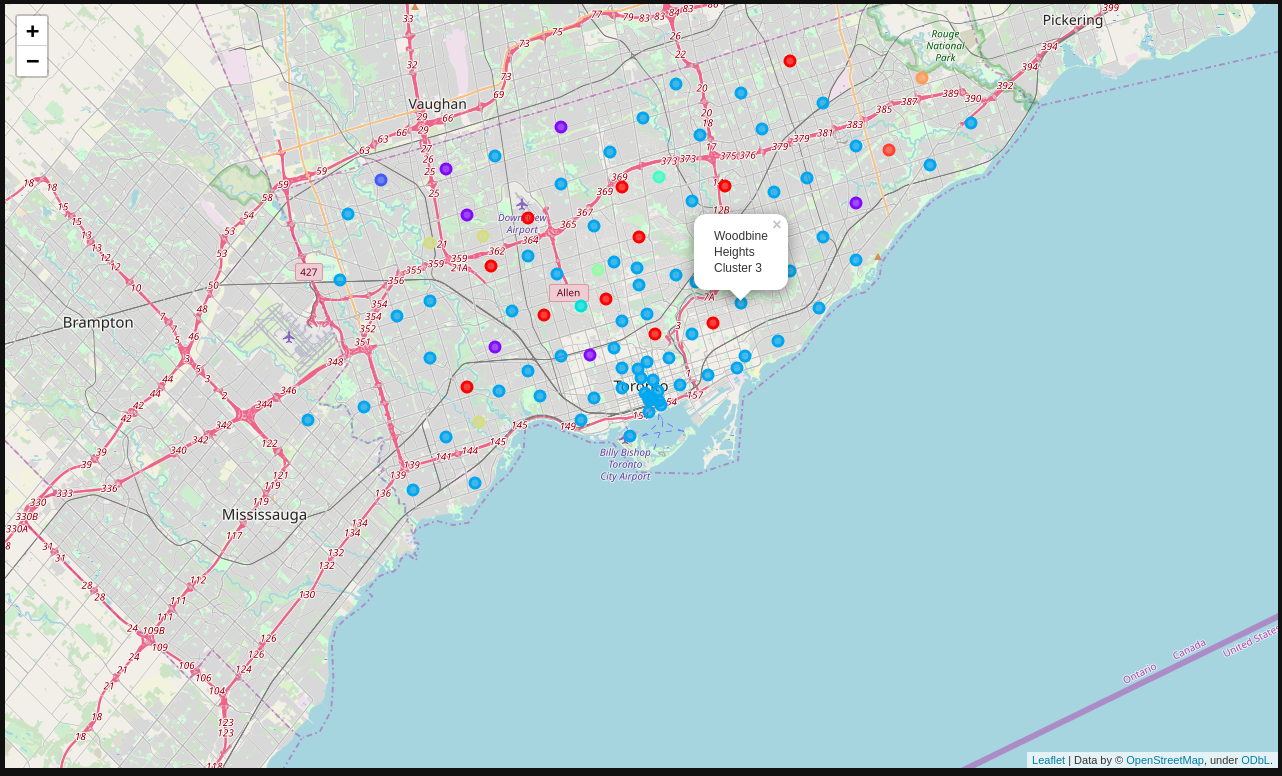

In [40]:
Image('img/task 3 - result.png')